# <font color=blue> __InferPloidy Application Example__  </font>
MLBI-lab@DKU, May 20, 2025

In [ ]:
## Required python packages
'''
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install scikit-network
'''
!pip install gdown
!pip install scanpy
!pip install infercnvpy
!pip install inferploidy --upgrade


In [10]:
## Import required packages
import copy, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from inferploidy import run_inferploidy, run_infercnv, plot_cnv, load_sample_data

warnings.filterwarnings('ignore')

### __Load data with celltype annotations__

In [3]:
data = 'BRCA' # 'BRCA', 'NSCLC', 'PDAC', 'CRC'
tissue = 'Breast' # 'Breast', 'Lung', 'Pancreas', 'Intestine'

adata = load_sample_data( data )
adata

Downloading...
From (original): https://drive.google.com/uc?export=download&id=158LUiHiJNFzYvqY-QzMUm5cvIznBrUAV
From (redirected): https://drive.google.com/uc?export=download&id=158LUiHiJNFzYvqY-QzMUm5cvIznBrUAV&confirm=t&uuid=e60a4052-7064-4eae-9f76-9fc9de274523
To: /content/downloaded
100%|██████████| 124M/124M [00:01<00:00, 101MB/s] 


File saved to: BRCA.h5ad


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset'

### __Run InferCNV and InferPloidy__

In [4]:
ref_key = 'celltype_major'
ref_cat = ['T cell', 'B cell', 'Myeloid cell', 'Fibroblast', 'Acinar cell']

run_infercnv(adata, ref_key = ref_key, ref_cat = ref_cat,
             gtf_file = None, species = 'hs',
             window_size = 100, n_cores = 4 )

  0%|          | 0/7 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset', 'cnv_ref_ind'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'cnv'
    obsm: 'X_cnv'

In [5]:
adata = run_inferploidy( adata, ref_key = ref_key, ref_cat = ref_cat,
                         N_runs = 7, n_cores = 4, verbose = True,
                         clustering_resolution = 6 )
adata

InferPloidy .. 
   1/7
   2/7
   3/7
   4/7
   5/7
   6/7
   7/7
InferPloidy .. done. (1830) 


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset', 'cnv_ref_ind', 'iploidy_score', 'iploidy_dec', 'iploidy_init_group'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'cnv'
    obsm: 'X_cnv', 'X_cnv_pca'

### __Check out CNV pattern__

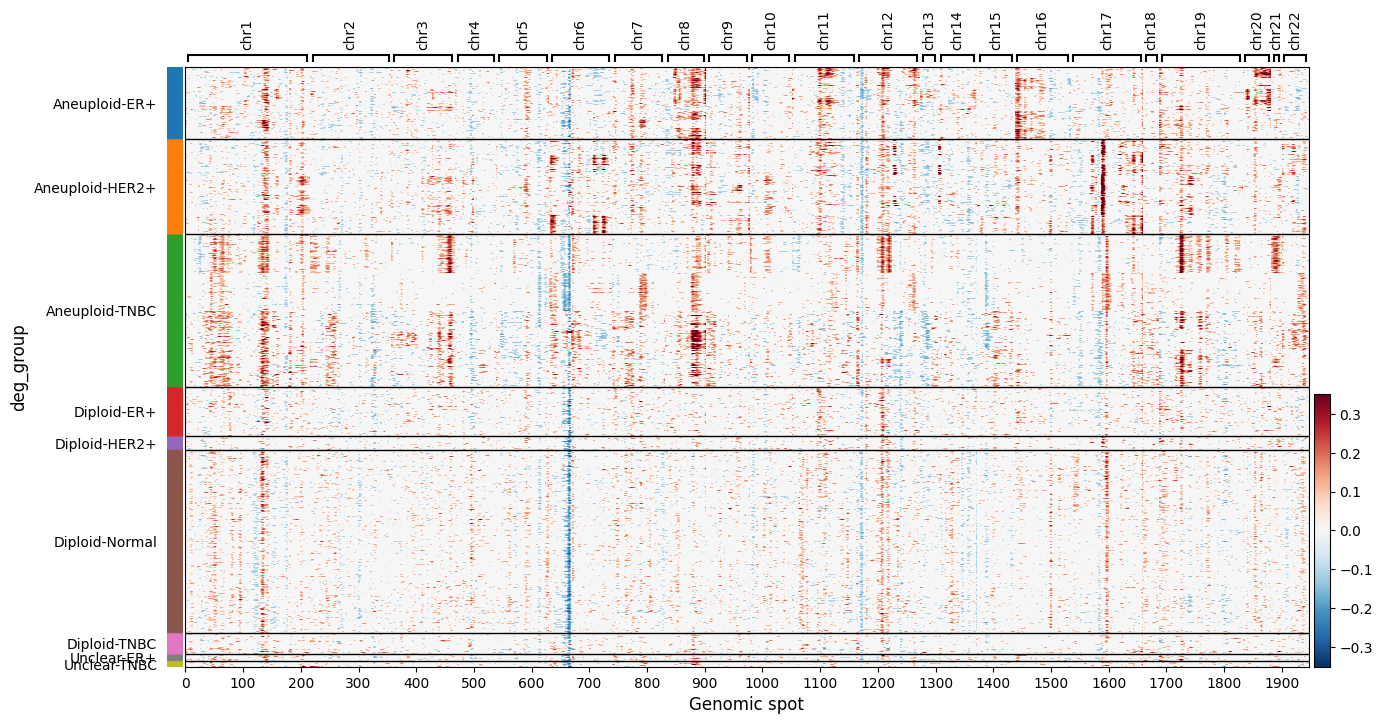

In [6]:
b = adata.obs['celltype_major'].isin(['Epithelial cell', 'Lung Epithelial cell', 'Ductal cell'])
adata_s = adata[b,:]

lst1 = list(adata_s.obs['iploidy_dec'])
lst2 = list(adata_s.obs['condition'])
deg_grouping = 'deg_group'
adata_s.obs[deg_grouping] = ['%s-%s' % (a1, a2) for a1, a2 in zip(lst1, lst2)]

## Select samples with the number of cells >= min.value
pcnt = adata_s.obs[deg_grouping].value_counts()
bp = pcnt >= 50
b = adata_s.obs[deg_grouping].isin(list(pcnt.index.values[bp]))
adata_s = adata_s[b,:]

## Plot CNV patterns of cell groups
axd = plot_cnv( adata_s, groupby = deg_grouping,
                title = '',
                title_fs = 15, title_y_pos = 1.11,
                label_fs = 12, tick_fs = 10,
                figsize = (15, 8), swap_axes = False,
                var_group_rotation = 90, cmap='RdBu_r', vmax = 1,
                cnv_obsm_key = 'X_cnv', cnv_uns_key = 'cnv')


### __CNV UMAP__

In [7]:
## Perform UMAP projection of CNV patterns
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep = 'X_cnv_pca', key_added = 'cnv_neighbors')
ad_tmp = sc.tl.umap(adata, neighbors_key = 'cnv_neighbors', copy = True)
adata.obsm['X_cnv_umap'] = ad_tmp.obsm['X_umap']

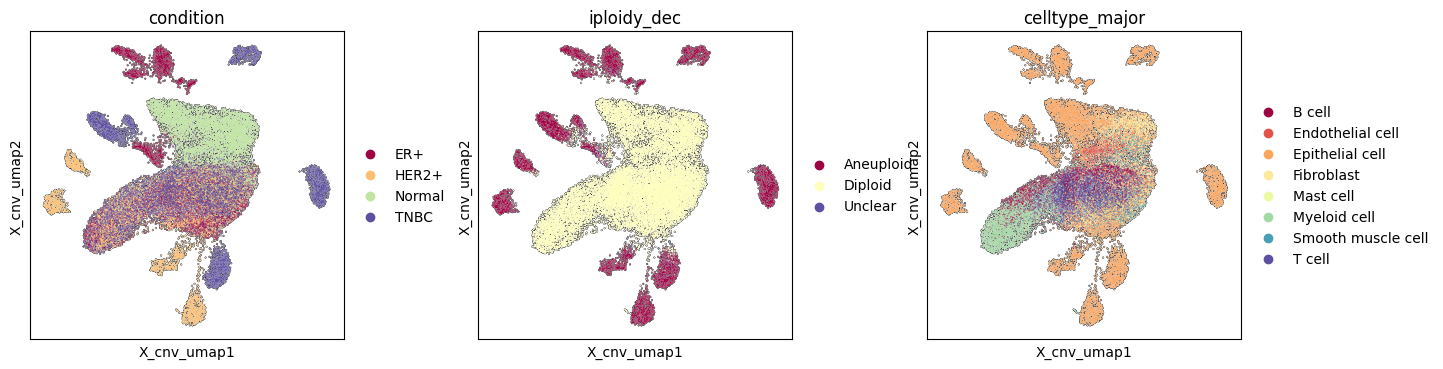

In [8]:
items_to_plot = ['condition', 'iploidy_dec', 'celltype_major']

plt.rcParams['figure.figsize'] = (4, 4)
fig = sc.pl.embedding( adata, basis = 'X_cnv_umap', neighbors_key = 'cnv_neighbors',
                       color=items_to_plot, wspace = 0.3, legend_fontsize = 10,
                       ncols = 3, palette = 'Spectral', return_fig = False,
                       add_outline = True, s = 3)

### __Marker discovery (using SCODA-processed data)__

In [14]:
from scodaviz import load_scoda_processed_sample_data, find_condition_specific_markers, plot_marker_exp

In [21]:
adata = load_scoda_processed_sample_data(data)
adata

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1XbX8Q3dH1kOWnM6ppms4BR2ukEAKYisB
From (redirected): https://drive.google.com/uc?export=download&id=1XbX8Q3dH1kOWnM6ppms4BR2ukEAKYisB&confirm=t&uuid=0e06a7d3-644d-4769-991b-dc336d3871c8
To: /mnt/HDD2/Google_drive/PyPI_Git_Publish/pub_inferploidy_open/downloaded
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258M/258M [00:26<00:00, 9.72MB/s]


File saved to: BRCA_428K_GSE161529_33K_v1.h5ad


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'copykat_dec', 'scevan_dec', 'sample_ext', 'celltype_major', 'celltype_minor', 'celltype_subset', 'cnv_ref_ind', 'ploidy_score', 'ploidy_dec', 'ploidy_init_group', 'condition_for_deg', 'sample_ext_for_deg', 'celltype_for_deg', 'celltype_for_cci', 'tumor_origin_ind'
    var: 'variable_genes', 'chr', 'spot_no'
    uns: 'CCI', 'CCI_sample', 'Celltype_marker_DB', 'DEG', 'DEG_grouping_vars', 'DEG_stat', 'DEG_vs_ref', 'DEG_vs_ref_stat', 'GSA_down', 'GSA_up', 'GSA_vs_ref_down', 'GSA_vs_ref_up', 'GSEA', 'GSEA_vs_ref', 'Pathways_DB', 'analysis_parameters', 'cnv', 'cnv_neighbors_info', 'inferploidy_summary', 'log', 'lut_sample_to_cond', 'usr_param'
    obsm: 'HiCAT_result', 'X_cnv', 'X_cnv_pca', 'X_pca', 'i

In [25]:
target_cell = 'Epithelial cell'

df_deg_lst = adata.uns['DEG'][target_cell]
mkr_dict = find_condition_specific_markers( df_deg_lst,
                                            n_markers_max = 60,
                                            score_th = 0.25,
                                            pval_cutoff = 0.05,
                                            verbose = True,
                                            surfaceome_only = True )

## Print results
for key in mkr_dict.keys():
    mkr_dict[key].sort()
    print('%s (%i): ' % (key, len(mkr_dict[key])), mkr_dict[key])

N_markers: 
   Diploid_vs_others (8879 -> 0) 
   ER+_vs_others (10250 -> 39) 
   HER2+_vs_others (9982 -> 17) 
   Normal_vs_others (9793 -> 51) 
   TNBC_vs_others (10746 -> 36)
N_markers_selected: Diploid (0), ER+ (39), HER2+ (17), Normal (51), TNBC (36)
Diploid (0):  []
ER+ (39):  ['BCAM', 'BST2', 'CA12', 'CD151', 'CD46', 'CELSR2', 'CLDN7', 'ERBB3', 'ESR1', 'FAM174A', 'GFRA1', 'GPRC5A', 'LDLRAD4', 'MUC1', 'NECTIN2', 'PIGT', 'PRLR', 'PRSS8', 'PTPRA', 'SDC1', 'SERINC2', 'SERINC3', 'SEZ6L2', 'SIGIRR', 'SLC39A6', 'SLC40A1', 'SLC44A4', 'SLC49A3', 'SLC7A2', 'SUSD3', 'SYPL1', 'TGOLN2', 'TMCO3', 'TMEM179B', 'TMEM219', 'TMEM25', 'TPBG', 'TSPAN1', 'TSPAN13']
HER2+ (17):  ['ADAM10', 'CD164', 'CPD', 'CRB3', 'DDR1', 'ERBB2', 'ERMP1', 'FAM174B', 'GINM1', 'GPR160', 'HLA-DRA', 'LRP10', 'SCARB2', 'STT3B', 'TM9SF3', 'TMEM132A', 'TSPAN5']
Normal (51):  ['ABCC3', 'ADAM9', 'ATP13A3', 'BACE2', 'CD44', 'CD55', 'CDCP1', 'CEACAM1', 'CLDND1', 'CRIM1', 'CXCL16', 'EGFR', 'EMP1', 'EMP3', 'EPHA2', 'EVA1C', 'F3', '

Num markers selected: 92 -> 92


... storing 'condition_for_deg' as categorical
... storing 'sample_ext_for_deg' as categorical


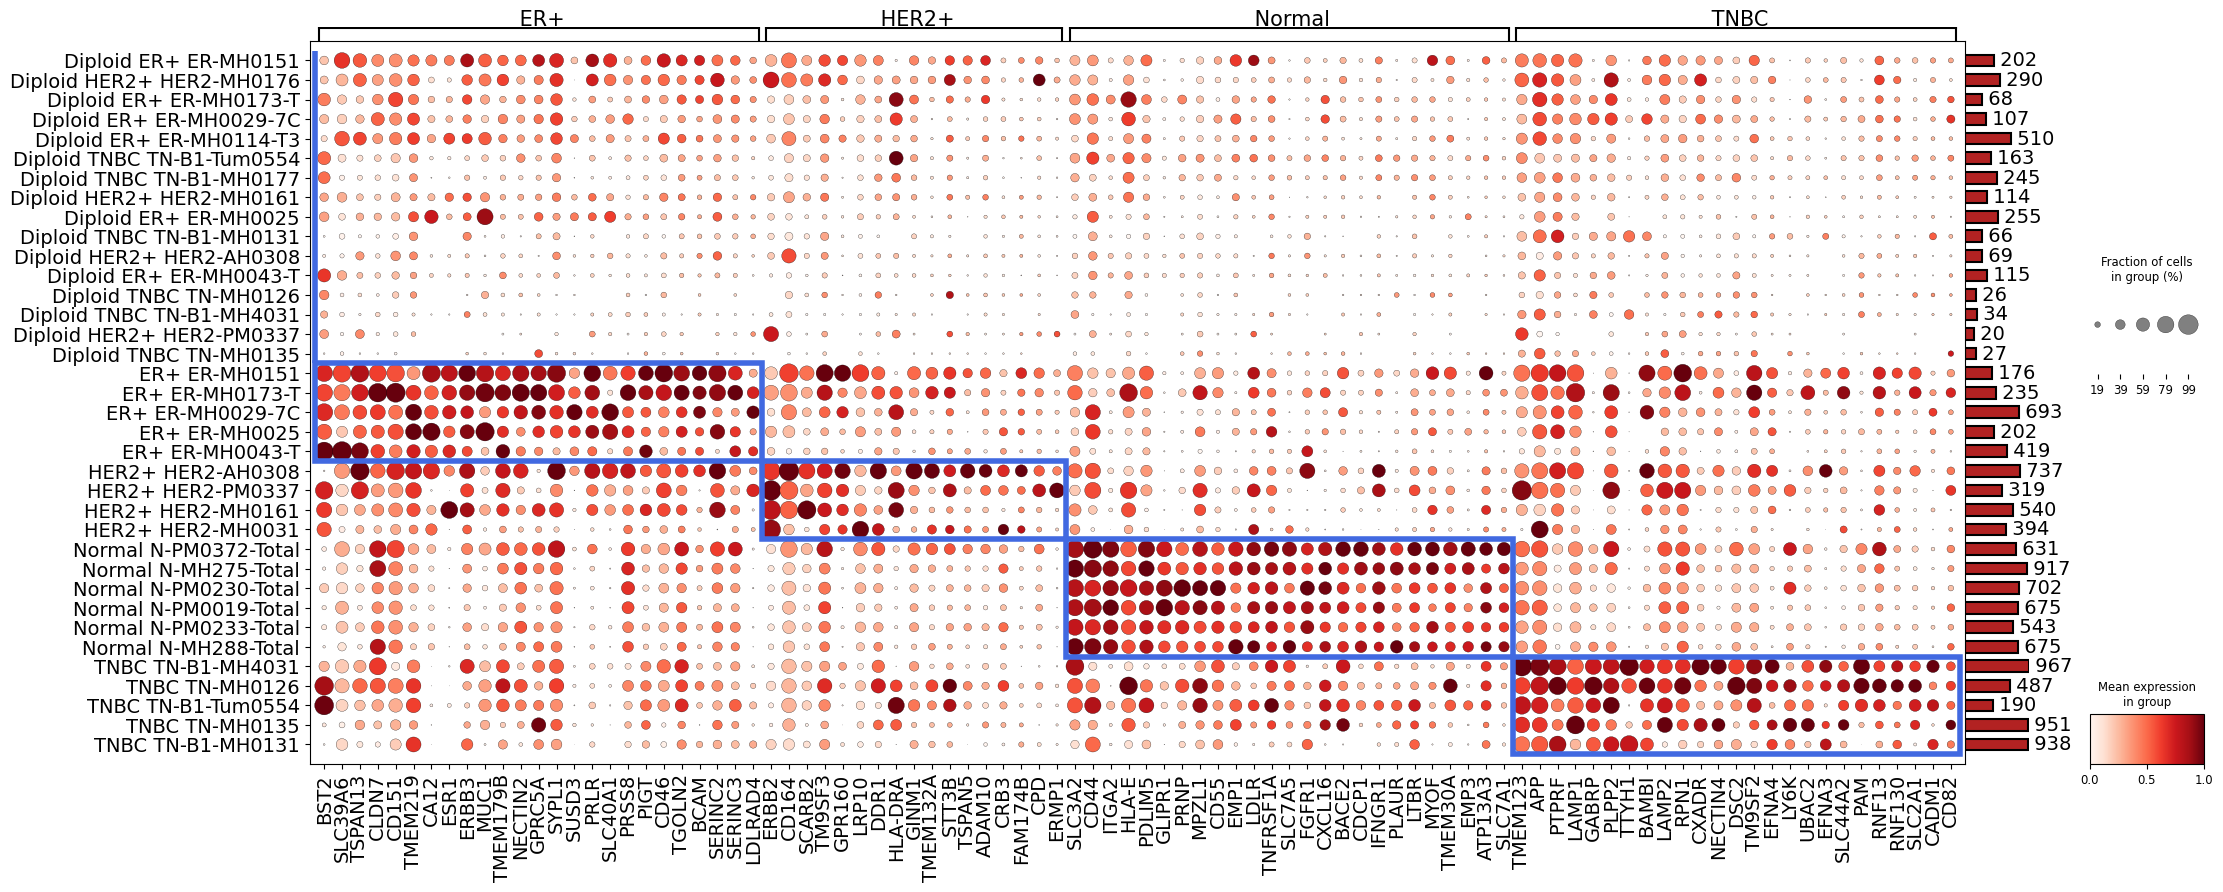

In [26]:
celltype_col = adata.uns['DEG_grouping_vars'][target_cell]['celltype col']
cond_col = adata.uns['DEG_grouping_vars'][target_cell]['condition col']
sample_col = adata.uns['DEG_grouping_vars'][target_cell]['sample col']

b = adata.obs['tumor_origin_ind']
adata_s = adata[b,:]

## Select samples with its No. of cells greater than 40
pcnt = adata_s.obs[sample_col].value_counts()
b = pcnt >= 20
b = adata_s.obs[sample_col].isin(pcnt.index.values[b])
adata_ss = adata_s[b,:]

## UMAP with celltype annotation, sample, condition
sc.pp.normalize_total(adata_ss, target_sum=1e4)
sc.pp.log1p(adata_ss)

plot_marker_exp(adata_ss, markers = mkr_dict, var_group_col = cond_col,
                group_col = sample_col, group_categ_col = cond_col,
                title = None, title_y_pos = 2, title_fs = 24,
                text_fs = 14, linewidth = 4,
                var_group_height = 1.2, var_group_rotation = 0,
                standard_scale = 'var', nz_frac_max = 0.99, nz_frac_cutoff = 0.05,
                rem_mkrs_common_in_N_groups_or_more = 3, N_cells_min = 20,
                N_markers_per_group_max = 25, N_markers_total = 140,
                figsize = (24, 5), swap_ax = False, legend = True,
                add_rect = True )